In [1]:
# we will import all the necessary libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance
from operator import itemgetter
from networkx.algorithms import tournament

In [2]:
london = nx.read_graphml('london.graph')
print(nx.info(london))


Graph with 401 nodes and 467 edges


/tmp/ipykernel_3353/2845480270.py:2: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(london))


In [3]:
#since coords tuples are stored as string, need to convert them back to tuples using eval()
for node in london.nodes():
    london.nodes[node]['coords'] = eval(london.nodes[node]['coords'])



In [4]:
# change 0 in flows to 1
for edge in london.edges():
    if london.edges[edge]['flows'] == 0:
        london.edges[edge]['flows'] = 1

In [7]:
#london.edges['Kennington', 'Nine Elms']

{'length': 2030.5945008723893, 'line_name': 'Northern', 'flows': 1}

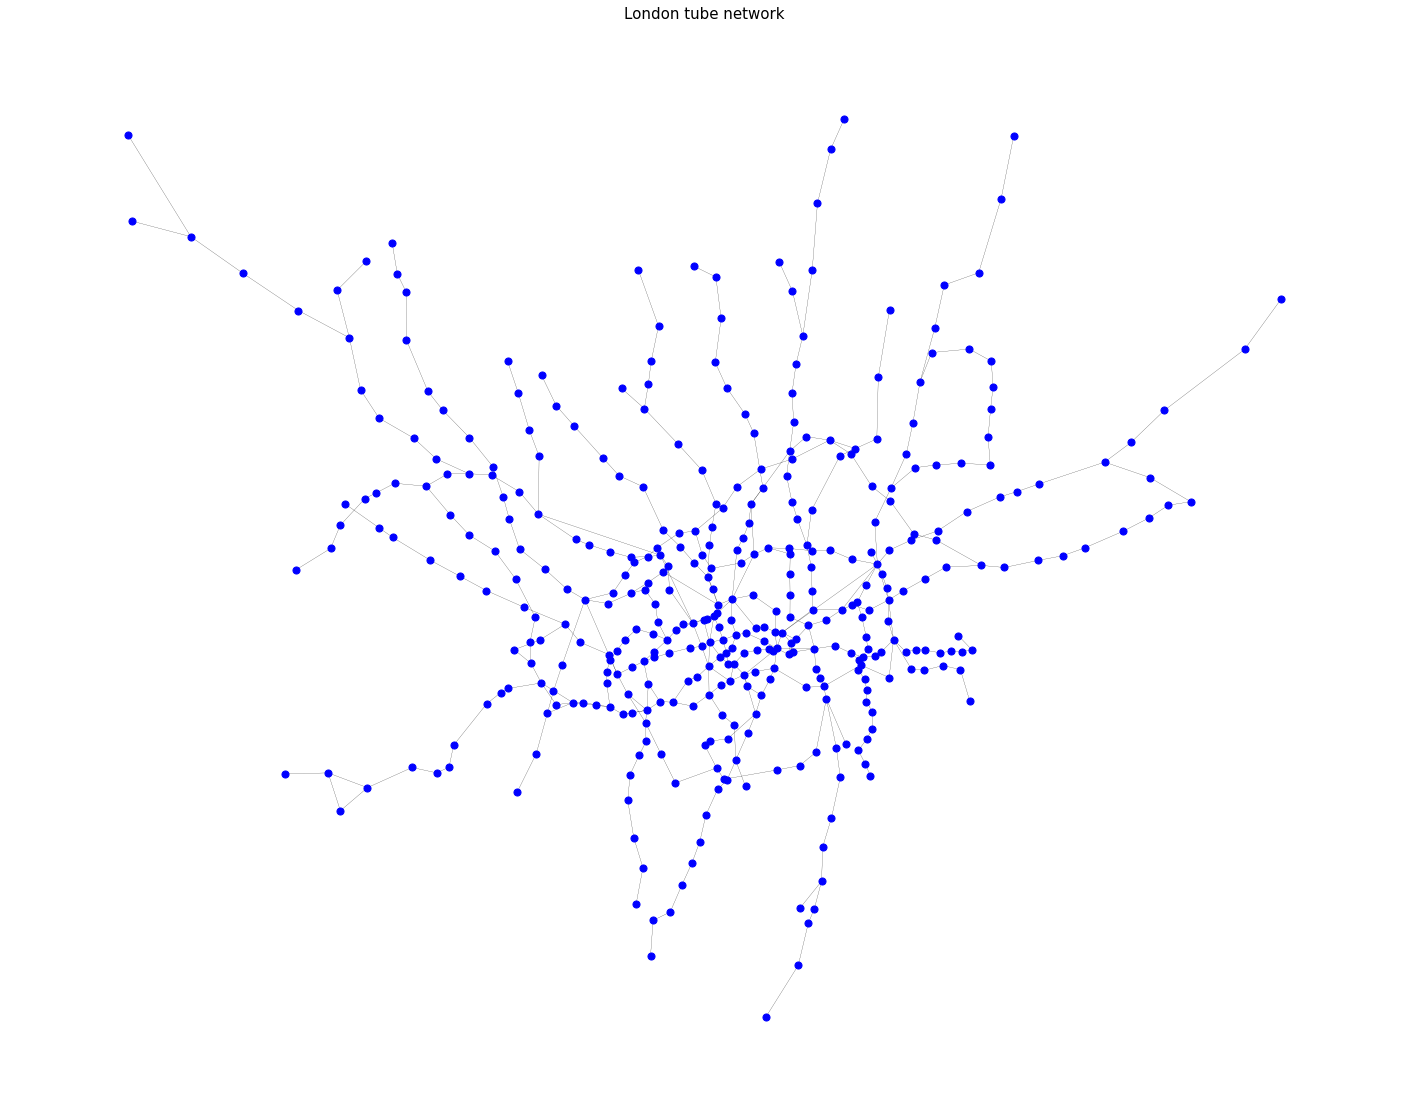

In [5]:
# Let's plot the tube network! 

# We can plot the tube network with the names of the stations as labels
fig, ax = plt.subplots(figsize=(25,20))

node_labels = nx.get_edge_attributes(london, 'source')

pos = nx.get_node_attributes(london, 'coords')

nx.draw_networkx_nodes(london,pos,node_size=50,node_color='b')
nx.draw_networkx_edges(london,pos,arrows=False,width=0.2)
nx.draw_networkx_labels(london,pos, node_labels, font_size=10, font_color='black')

plt.title("London tube network",fontsize=15)
plt.axis("off")
plt.show()

## Topological Closeness Centrality

In [5]:
clos_t=nx.closeness_centrality(london)
# We can add these values to the nodes attributes:
nx.set_node_attributes(london,clos_t,'clos_t')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=london.nodes())
df['station_name'] = london.nodes()
df['clos_t'] = pd.Series(nx.get_node_attributes(london, 'clos_t'))

df_sorted = df.sort_values(["clos_t"], ascending=False)
df_sorted = df_sorted.reset_index(drop = True)
df_sorted[0:10]

,station_name,clos_t
0,Green Park,0.114778
1,Bank and Monument,0.113572
2,King's Cross St. Pancras,0.113443
3,Westminster,0.112549
4,Waterloo,0.112265
5,Oxford Circus,0.111204
6,Bond Street,0.110988
7,Farringdon,0.110742
8,Angel,0.110742
9,Moorgate,0.110314


## Eigenvector centrality

In [6]:
eigen_t=nx.eigenvector_centrality(london, max_iter = 600)
# We can add these values to the nodes attributes:
nx.set_node_attributes(london,eigen_t,'eigen_t')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=london.nodes())
df['station_name'] = london.nodes()
#df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['eigen_t'] = pd.Series(nx.get_node_attributes(london, 'eigen_t'))

df_sorted = df.sort_values(["eigen_t"], ascending=False)
df_sorted = df_sorted.reset_index(drop = True)
df_sorted[0:10]

,station_name,eigen_t
0,Bank and Monument,0.383427
1,Liverpool Street,0.328824
2,Stratford,0.269179
3,Waterloo,0.249731
4,Moorgate,0.215137
5,Green Park,0.197630
6,Oxford Circus,0.184094
7,Tower Hill,0.171676
8,Westminster,0.168610
9,Shadwell,0.159090


## Topological Betweenness

In [7]:
#Let us compute the betweenness centrality for the network, without using weights:
bet_london_t=nx.betweenness_centrality(london, normalized=False)
# We can add these values to the nodes attributes:
nx.set_node_attributes(london,bet_london_t,'bet_t')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=london.nodes())
df['station_name'] = london.nodes()
#df['station_name'] = pd.Series(nx.get_node_attributes(london, 'station_name'))
df['bet_t'] = pd.Series(nx.get_node_attributes(london, 'bet_t'))

df_sorted = df.sort_values(["bet_t"], ascending=False)
df_sorted = df_sorted.reset_index(drop = True)
df_sorted[0:10]

,station_name,bet_t
0,Stratford,23768.093434
1,Bank and Monument,23181.058947
2,Liverpool Street,21610.387049
3,King's Cross St. Pancras,20373.521465
4,Waterloo,19464.882323
5,Green Park,17223.622114
6,Euston,16624.275469
7,Westminster,16226.155916
8,Baker Street,15287.107612
9,Finchley Road,13173.758009


# I.3 drop and measure

In [8]:
eff0 = nx.global_efficiency(london)
g_d0 = nx.density(london)
print(g_d0)

0.005822942643391521


In [26]:
def nodes_removal(met, num):

# I.3.A drop nodes with highest value by different method

    
    g = london.copy()
    values_sorted = sorted(met.items(), key=itemgetter(1), reverse=True)
    sorted_nodes=[e for e,v in values_sorted[:num]]
    g.remove_nodes_from(sorted_nodes)
    components = nx.connected_components(g)
    largest_component = max(components, key=len)
    Largest_subgraph = g.subgraph(largest_component)
    num_nodes = Largest_subgraph.number_of_nodes()
    g_eff = nx.global_efficiency(g)
    g_d = nx.density(g)
    
    return sorted_nodes[num-1], num_nodes, g_d

## drop by betweenness

In [27]:
def bet_removal(g):

# I.3.B drop nodes with highest value by betweeness

    bet_t=nx.betweenness_centrality(g, normalized=False)
    values_sorted = sorted(bet_t.items(), key=itemgetter(1), reverse=True)
    highest = [e for e,v in values_sorted[:1]]
    g.remove_nodes_from(highest)
    components = nx.connected_components(g)
    largest_component = max(components, key=len)
    Largest_subgraph = g.subgraph(largest_component)
    num_nodes = Largest_subgraph.number_of_nodes()
    g_d = nx.density(g)
    
    return highest[0], num_nodes, g_d

In [28]:
london1 = london.copy()
# To remove  10 highest values:
# List of nodes:
values_sorted = sorted(bet_london_t.items(), key=itemgetter(1), reverse=True)
sorted_ten=[e for e,v in values_sorted[:10]]
sorted_ten

['Stratford',
 'Bank and Monument',
 'Liverpool Street',
 "King's Cross St. Pancras",
 'Waterloo',
 'Green Park',
 'Euston',
 'Westminster',
 'Baker Street',
 'Finchley Road']

In [29]:
# I.3.A
print("%-30s\t %-25s\t %-20s\t %-12s"%("station deleted","Largest component size","global density","delta d"))
for i in range (1,11):
    deleted_nodes, LCC, g_d = nodes_removal(bet_london_t, i)

    print("%-30s\t %-25s\t %-20s\t %-12s"%(deleted_nodes, LCC, g_d, g_d0 - g_d))



station deleted               	 Largest component size   	 global density      	 delta d     
Stratford                     	 379                      	 0.005739348370927318	 8.359427246420244e-05
Bank and Monument             	 378                      	 0.0056674349189556805	 0.00015550772443584035
Liverpool Street              	 377                      	 0.005645355239674443	 0.00017758740371707788
King's Cross St. Pancras      	 371                      	 0.00558481540849299 	 0.00023812723489853062
Waterloo                      	 370                      	 0.005549162511187828	 0.0002737801322036928
Green Park                    	 369                      	 0.005500224892372936	 0.00032271775101858514
Euston                        	 346                      	 0.005476550289973005	 0.00034639235341851586
Westminster                   	 345                      	 0.005478527288778107	 0.000344415354613414
Baker Street                  	 342                      	 0.0054152095620857

In [30]:
# I.3.B
print("%-30s\t %-25s\t %-20s\t %-12s"%("station deleted","Largest component size","global density","delta d"))
g1 = london.copy()
for i in range (1,11):
    deleted_nodes, LCC, g_d = bet_removal(g1)
    

    print("%-30s\t %-25s\t %-20s\t %-12s"%(deleted_nodes, LCC, g_d, g_d0 - g_d))


station deleted               	 Largest component size   	 global density      	 delta d     
Stratford                     	 379                      	 0.005739348370927318	 8.359427246420244e-05
King's Cross St. Pancras      	 378                      	 0.005680029218775582	 0.00014291342461593848
Waterloo                      	 377                      	 0.005632697492500285	 0.00019024515089123561
Bank and Monument             	 376                      	 0.0055720937333028015	 0.00025084891008871936
Canada Water                  	 375                      	 0.005549162511187828	 0.0002737801322036928
West Hampstead                	 227                      	 0.005525926877851314	 0.00029701576554020705
Earl's Court                  	 226                      	 0.005476550289973005	 0.00034639235341851586
Shepherd's Bush               	 196                      	 0.0054525627044711015	 0.0003703799389204194
Euston                        	 173                      	 0.00542825825982

## drop by closeness

In [43]:
def clos_removal(g):

# I.3.B drop nodes with highest value by closeness

    clos_t=nx.closeness_centrality(g)
    values_sorted = sorted(clos_t.items(), key=itemgetter(1), reverse=True)
    highest = [e for e,v in values_sorted[:1]]
    g.remove_nodes_from(highest)
    components = nx.connected_components(g)
    largest_component = max(components, key=len)
    Largest_subgraph = g.subgraph(largest_component)
    num_nodes = Largest_subgraph.number_of_nodes()
    g_eff = nx.global_efficiency(g)
    g_d = nx.density(g)
    
    return highest[0], num_nodes, g_d

In [40]:
london2 = london.copy()
# To remove  10 highest values:
# List of nodes:
values_sorted = sorted(clos_t.items(), key=itemgetter(1), reverse=True)
sorted_ten=[e for e,v in values_sorted[:10]]
#sorted_ten

In [41]:
# I.3.A
print("%-30s\t %-25s\t %-20s\t %-12s"%("station deleted","Largest component size","global density","delta d"))
for i in range (1, 11):
    deleted_nodes,LCC, g_d = nodes_removal(clos_t, i)

    print("%-30s\t %-25s\t %-20s\t %-12s"%(deleted_nodes, LCC, g_d, g_d0 - g_d))

station deleted               	 Largest component size   	 global density      	 delta d     
Green Park                    	 400                      	 0.005776942355889724	 4.600028750179671e-05
Bank and Monument             	 399                      	 0.005705217818415385	 0.00011772482497613562
King's Cross St. Pancras      	 398                      	 0.005645355239674443	 0.00017758740371707788
Westminster                   	 397                      	 0.005635702109253747	 0.00018724053413777392
Waterloo                      	 396                      	 0.005613092954865106	 0.0002098496885264145
Oxford Circus                 	 395                      	 0.005577330848808071	 0.00024561179458345
Bond Street                   	 394                      	 0.005579881427519666	 0.00024306121587185526
Farringdon                    	 393                      	 0.00559536791815963 	 0.00022757472523189052
Angel                         	 392                      	 0.005610940028185187

In [44]:
# I.3.B
g2 = london.copy()
print("%-30s\t %-25s\t %-20s\t %-12s"%("station deleted","Largest component size","global density","delta d"))

for i in range (1,11):
    deleted_nodes, LCC, g_d = clos_removal(g2)
    

    print("%-30s\t %-25s\t %-20s\t %-12s"%(deleted_nodes, LCC, g_d, g_d0 - g_d))

station deleted               	 Largest component size   	 global density      	 delta d     
Green Park                    	 400                      	 0.005776942355889724	 4.600028750179671e-05
King's Cross St. Pancras      	 399                      	 0.005717812118235287	 0.00010513052515623376
Waterloo                      	 398                      	 0.005670670734022758	 0.0001522719093687624
Bank and Monument             	 397                      	 0.005610258758873369	 0.00021268388451815227
West Hampstead                	 396                      	 0.005587520777394195	 0.00023542186599732548
Canada Water                  	 226                      	 0.005564479856068881	 0.0002584627873226395
Stratford                     	 226                      	 0.005476550289973005	 0.00034639235341851586
Earl's Court                  	 225                      	 0.005426598120164096	 0.0003963445232274248
Shepherd's Bush               	 195                      	 0.00540216086434573

## drop by eigenvector

In [45]:
def eigen_removal(g):

# I.3.B drop nodes with highest value by eigenvector

    eigen_t=nx.eigenvector_centrality(g, max_iter = 600)
    values_sorted = sorted(eigen_t.items(), key=itemgetter(1), reverse=True)
    highest = [e for e,v in values_sorted[:1]]
    g.remove_nodes_from(highest)
    components = nx.connected_components(g)
    largest_component = max(components, key=len)
    Largest_subgraph = g.subgraph(largest_component)
    num_nodes = Largest_subgraph.number_of_nodes()
    g_eff = nx.global_efficiency(g)
    g_d = nx.density(g)
    
    return highest[0], num_nodes, g_d

In [46]:
london3 = london.copy()
# To remove  10 highest values:
# List of nodes:
values_sorted = sorted(eigen_t.items(), key=itemgetter(1), reverse=True)
sorted_ten=[e for e,v in values_sorted[:10]]

#sorted_ten

In [47]:
# I.3.A
print("%-30s\t %-25s\t %-20s\t %-12s"%("station deleted","Largest component size","global density","delta d"))
for i in range (1, 11):
    deleted_nodes, LCC, g_d = nodes_removal(eigen_t, i)

    print("%-30s\t %-25s\t %-20s\t %-12s"%(deleted_nodes, LCC, g_d, g_d0 - g_d))

station deleted               	 Largest component size   	 global density      	 delta d     
Bank and Monument             	 400                      	 0.00575187969924812 	 7.106294414340082e-05
Liverpool Street              	 399                      	 0.005717812118235287	 0.00010513052515623376
Stratford                     	 377                      	 0.005645355239674443	 0.00017758740371707788
Waterloo                      	 376                      	 0.005610258758873369	 0.00021268388451815227
Moorgate                      	 375                      	 0.005613092954865106	 0.0002098496885264145
Green Park                    	 374                      	 0.005564479856068881	 0.0002584627873226395
Oxford Circus                 	 373                      	 0.005528215858746335	 0.000294726784645186
Tower Hill                    	 371                      	 0.005530456457392117	 0.00029248618599940403
Westminster                   	 370                      	 0.005532647841745394

In [48]:
# I.3.B
g3 = london.copy()
print("%-30s\t %-25s\t %-20s\t %-12s"%("station deleted","Largest component size","global density","delta d"))
for i in range (1, 11):
    deleted_nodes, LCC, g_d = eigen_removal(g3)

    print("%-30s\t %-25s\t %-20s\t %-12s"%(deleted_nodes, LCC, g_d, g_d0 - g_d))

station deleted               	 Largest component size   	 global density      	 delta d     
Bank and Monument             	 400                      	 0.00575187969924812 	 7.106294414340082e-05
Oxford Circus                 	 399                      	 0.005705217818415385	 0.00011772482497613562
Stratford                     	 377                      	 0.005620039745326127	 0.00020290289806539422
Earl's Court                  	 376                      	 0.0055720937333028015	 0.00025084891008871936
Westminster                   	 375                      	 0.005549162511187828	 0.0002737801322036928
Baker Street                  	 373                      	 0.005487373899633747	 0.00033556874375777375
King's Cross St. Pancras      	 370                      	 0.005424884721199674	 0.0003980579221918466
Canning Town                  	 356                      	 0.005374668951550086	 0.00044827369184143474
Turnham Green                 	 355                      	 0.005336917375645

# II.1

## weighted closeness

In [49]:
# Note that we have to invert the weights, since they are meant to represent a distance.
# the higher the value to closer they are
c_weights={(e1, e2):round(1./weight,7) for e1, e2, weight in london.edges(data='flows')}

# Let us add the inverted weight as an attribute to the edges in the graph
nx.set_edge_attributes(london, c_weights, 'c_weights')

In [50]:
clos_w = nx.closeness_centrality(london, distance = 'c_weights')
# We can add these values to the nodes attributes:
nx.set_node_attributes(london,clos_w,'clos_w')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=london.nodes())
df['station_name'] = london.nodes()
df['clos_w'] = pd.Series(nx.get_node_attributes(london, 'clos_w'))
df['clos_t'] = pd.Series(nx.get_node_attributes(london, 'clos_t'))

df_sorted = df.sort_values(["clos_w"], ascending=False)
df_sorted = df_sorted.reset_index(drop = True)
df_sorted[0:10]

,station_name,clos_w,clos_t
0,Green Park,95.976854,0.114778
1,Westminster,95.969168,0.112549
2,Waterloo,95.962031,0.112265
3,Bank and Monument,95.960969,0.113572
4,Oxford Circus,95.939995,0.111204
5,Liverpool Street,95.928865,0.110254
6,Bond Street,95.925852,0.110988
7,Warren Street,95.901441,0.106242
8,Hyde Park Corner,95.900468,0.107296
9,Moorgate,95.895167,0.110314


## weigheted betweenness

In [51]:
### Weighted betweenness centrality:
#Let us compute the betweenness centrality for the network, considering the distance between stations:

bet_w=nx.betweenness_centrality(london, weight = 'c_weights', normalized=False)

# We can add these values to the nodes attributes:
nx.set_node_attributes(london, bet_w,'bet_w')

# To dataframe using the nodes as the index
df = pd.DataFrame(index=london.nodes())
df['station_name'] = london.nodes()
df['bet_w'] = pd.Series(nx.get_node_attributes(london, 'bet_w'))
df['bet_t'] = pd.Series(nx.get_node_attributes(london, 'bet_t'))

df_sorted = df.sort_values(["bet_w"], ascending=False)
df_sorted = df_sorted.reset_index(drop = True)
df_sorted[0:10]

,station_name,bet_w,bet_t
0,Green Park,43861.25,17223.622114
1,Bank and Monument,42030.00,23181.058947
2,Waterloo,33966.00,19464.882323
3,Westminster,29871.00,16226.155916
4,Liverpool Street,27459.00,21610.387049
5,Stratford,26933.00,23768.093434
6,Euston,21685.75,16624.275469
7,Oxford Circus,19723.00,4296.746032
8,Bond Street,19527.00,11298.961255
9,Baker Street,19182.00,15287.107612


## weighted eigenvector

In [52]:
# In this measure the weight is interpreted as the connection strength.
eigen_w = nx.eigenvector_centrality(london, weight = 'flows', max_iter = 600)
# We can add these values to the nodes attributes:
nx.set_node_attributes(london,eigen_w,'eigen_w')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=london.nodes())
df['station_name'] = london.nodes()
#df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['eigen_w'] = pd.Series(nx.get_node_attributes(london, 'eigen_w'))
df['eigen_t'] = pd.Series(nx.get_node_attributes(london, 'eigen_t'))

df_sorted = df.sort_values(["eigen_w"], ascending=False)
df_sorted = df_sorted.reset_index(drop = True)
df_sorted[0:10]

,station_name,eigen_w,eigen_t
0,Waterloo,0.554570,0.249731
1,Bank and Monument,0.536619,0.383427
2,Westminster,0.398184,0.168610
3,Green Park,0.273053,0.197630
4,Liverpool Street,0.267839,0.328824
5,Moorgate,0.146288,0.215137
6,London Bridge,0.144709,0.150175
7,Stratford,0.107823,0.269179
8,Oxford Circus,0.090942,0.184094
9,Bond Street,0.090430,0.131473


# II.2

## Weighted Impact Measure

## global efficiency

In [72]:
def weighted_global_eff(G):
    if nx.is_connected(G) == True:
        dff = nx.to_pandas_edgelist(G)
    else:

        components = nx.connected_components(G)
        largest_component = max(components, key=len)
        G1 = G.subgraph(largest_component)
        dff = nx.to_pandas_edgelist(G1)
    
    list_of_nodes = list(set(dff['source']).union(set(dff['target'])))
    accu = 0.
    for i in range(0, len(list_of_nodes) - 1):
        for j in range(i + 1, len(list_of_nodes)):
            i_j = nx.shortest_path_length(G, source=list_of_nodes[i], target=list_of_nodes[j], weight='c_weights')
            accu += 1 / i_j
    w_global_eff = (1 / (len(list_of_nodes) * (len(list_of_nodes) - 1))) * accu
  
    return w_global_eff


In [54]:
def weighted_density(g):
    add_flow = 0
    n = 0
    for edge in g.edges():
        add_flow = add_flow + g.edges[edge]['flows']
        n = n + 1
    d = add_flow * 2 / n / (n-1)
    return d
    


In [85]:
#w_eff0 = weighted_global_eff(london)
ave_cluster_coef0 = nx.average_clustering(london, weight='flows')
wiener_idx0 = nx.wiener_index(london, weight = 'c_weights')
d0 = weighted_density(london)
g_eff0 = weighted_global_eff(london)

In [86]:
print(ave_cluster_coef0)
print(g_eff0)
print(d0)

0.0012906035727316707
1331.2232652699097
91.26696749409527


In [81]:
def bet_removal_2(g):

# I.3.B drop nodes with highest value by betweeness

    bet_w1=nx.betweenness_centrality(g, normalized=False, weight = 'c_weights')
    values_sorted = sorted(bet_w1.items(), key=itemgetter(1), reverse=True)
    highest = [e for e,v in values_sorted[:1]]
    g.remove_nodes_from(highest)
    ave_cluster_coef = nx.average_clustering(g, weight='flows')
    g_eff = weighted_global_eff(g)
    d = weighted_density(g)
    #l_path = nx.average_shortest_path_length(g)
    
    return highest[0], ave_cluster_coef, d, g_eff

In [82]:
# II.3.B
print("%-30s\t %-32s\t %-10s"%("station deleted","global eff","weighted_density"))
g7 = london.copy()
count=0
for i in range (1,11):

    deleted_nodes, ave_cluster_coef, d, g_eff= bet_removal_2(g7) 
    #print(g_eff)
    #print(nx.is_connected(g7))

    print("%-30s\t %-32s\t %-10s"%(deleted_nodes, g_eff, d))

station deleted               	 global eff                      	 weighted_density
Green Park                    	 1172.466322828569               	 87.64129020088654
Bank and Monument             	 998.6533342018541               	 83.84149915020805
King's Cross St. Pancras      	 750.1099533808901               	 81.67412707210158
Canada Water                  	 636.6068512962759               	 81.02649264834139
Finchley Road                 	 571.7297616355197               	 80.88640899449338
Highbury & Islington          	 533.3376846249204               	 80.56254038879177
Blackhorse Road               	 907.6835037915957               	 81.56405331031134
Earl's Court                  	 812.7251635836823               	 81.56859045504996
Willesden Junction            	 773.2166414041725               	 82.44708489601092
Shepherd's Bush               	 781.6060619283317               	 82.67742344585871
